In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from datasets import Dataset
import pandas as pd
df = pd.read_csv("selected_questions_answers.csv")
dataset = Dataset.from_pandas(df)
selected_questions = dataset['Question']
selected_answers = dataset['Answer']

In [3]:
# ornek soru ve cevap
print("Örnek Soru:", selected_questions[999])
print("Örnek Cevap:", selected_answers[999])

Örnek Soru: En güçlü konuşma biçimini içeren cümleyi seçin.  (1) Fırtına bir canavar gibi şiddetleniyordu. (2) Fırtına bir aslan kadar vahşiydi. (3) Fırtına bir canavar kadar şiddetliydi. (4) Fırtına vahşi bir ejderhaydı.
Örnek Cevap: 4


In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

# modeli yükleme ve vektör çıkartma
def get_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to('cuda')
    return tokenizer, model

# temsil çıkarma işlevi
def get_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]

def get_embeddings_in_batches(texts, tokenizer, model, batch_size=100):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(batch_embeddings)
    return torch.cat(embeddings)


In [5]:
from scipy.spatial.distance import cosine
import numpy as np

# kosinus benzerliğini hesaplama işlevi
def calculate_similarity(embedding1, embedding2):
    # kosinus mesafesi benzerliğin tersi oldugundan bu nedenle 1-cosine(embedding1, embedding2) olarak hesaplıyoruz
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity


In [6]:
# top-1 ve top-5 başarı oranı hesaplama islevi
def calculate_top_k_success(questions, answers, tokenizer, model, batch_size=800, k=5):
    top1_count = 0
    top5_count = 0
    for idx, question in enumerate(questions):
        question_embedding = get_embeddings([question], tokenizer, model)[0].cpu().numpy()
        # tum cevapların embedding'lerini hesaplayalım

        similarities = []
        for i in range(0, len(answers), batch_size):
            batch_answers = answers[i:i + batch_size]
            batch_answer_embeddings = get_embeddings(batch_answers, tokenizer, model).cpu().numpy()

            # Soru ile bu parti arasındaki benzerlik skorlarını hesapla
            batch_similarities = [calculate_similarity(question_embedding, answer) for answer in batch_answer_embeddings]
            similarities.extend(batch_similarities)


        sorted_indices = np.argsort(similarities)[::-1]
        top_k_indices = sorted_indices[:k]

        # gercek cevabın indeksi k içerisinde ise sayacı arttıralım
        # idx = index
        if idx in top_k_indices:
            top5_count += 1
            if top_k_indices[0] == idx:
                top1_count += 1
        # ilk seferde calisip calismadigindan emin olmak icin step sayaci koydum bundan sonraki tum modellerde bu sayaci 50 ser 50 ser arttiriyorum cok fazla otuput olmamasi icin
        print('Step Complete - Index:',idx)
    top1_success_rate = top1_count / len(questions)
    top5_success_rate = top5_count / len(questions)

    return top1_success_rate, top5_success_rate

In [ ]:
# Model 1 - KaLM-embedding-multilingual-mini-v1
# Model 2 - pingkeest/learning2_model
# Model 3 - sentence-transformers/paraphrase-multilingual-mpnet-base-v2
# Model 4 - Alibaba-NLP/gte-multilingual-base
# Model 5 - Alibaba-NLP/gte-large-en-v1.5
# Model 6 - dbmdz/bert-base-turkish-cased

# kullanilacak model isimlerinin listesi
# ilk basta planim sirayla modelleri calistirmakti ancak uzun surmesinden oturu paralel olarak modelleri boldum
# ve kodu bir bir her model icin parelel olarak calistirdim
custom_model_names = [
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
]

# her model için top-1 ve top-5 başarı oranlarını hesaplayalım
results = {}
for model_name in custom_model_names:
    print(f"Model: {model_name} yükleniyor...")
    tokenizer, model = get_model_and_tokenizer(model_name)

    print(f"{model_name} için top-1 ve top-5 başarı oranları hesaplanıyor...")
    top1_rate, top5_rate = calculate_top_k_success(selected_answers, selected_questions, tokenizer, model)

    results[model_name] = {
        "top1": top1_rate,
        "top5": top5_rate
    }

    print(f"{model_name} - Top-1 Başarı Oranı: {top1_rate:.2%}, Top-5 Başarı Oranı: {top5_rate:.2%}\n")



Model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2 yükleniyor...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


sentence-transformers/paraphrase-multilingual-mpnet-base-v2 için top-1 ve top-5 başarı oranları hesaplanıyor...
Step Complete - Index: 0
Step Complete - Index: 1
Step Complete - Index: 2
Step Complete - Index: 3
Step Complete - Index: 4
Step Complete - Index: 5
Step Complete - Index: 6
Step Complete - Index: 7
Step Complete - Index: 8
Step Complete - Index: 9
Step Complete - Index: 10
Step Complete - Index: 11
Step Complete - Index: 12
Step Complete - Index: 13
Step Complete - Index: 14
Step Complete - Index: 15
Step Complete - Index: 16
Step Complete - Index: 17
Step Complete - Index: 18
Step Complete - Index: 19
Step Complete - Index: 20
Step Complete - Index: 21
Step Complete - Index: 22
Step Complete - Index: 23
Step Complete - Index: 24
Step Complete - Index: 25
Step Complete - Index: 26
Step Complete - Index: 27
Step Complete - Index: 28
Step Complete - Index: 29
Step Complete - Index: 30
Step Complete - Index: 31
Step Complete - Index: 32
Step Complete - Index: 33
Step Complete 

sentence-transformers/paraphrase-multilingual-mpnet-base-v2 için t-SNE görselleştirmesi oluşturuluyor...


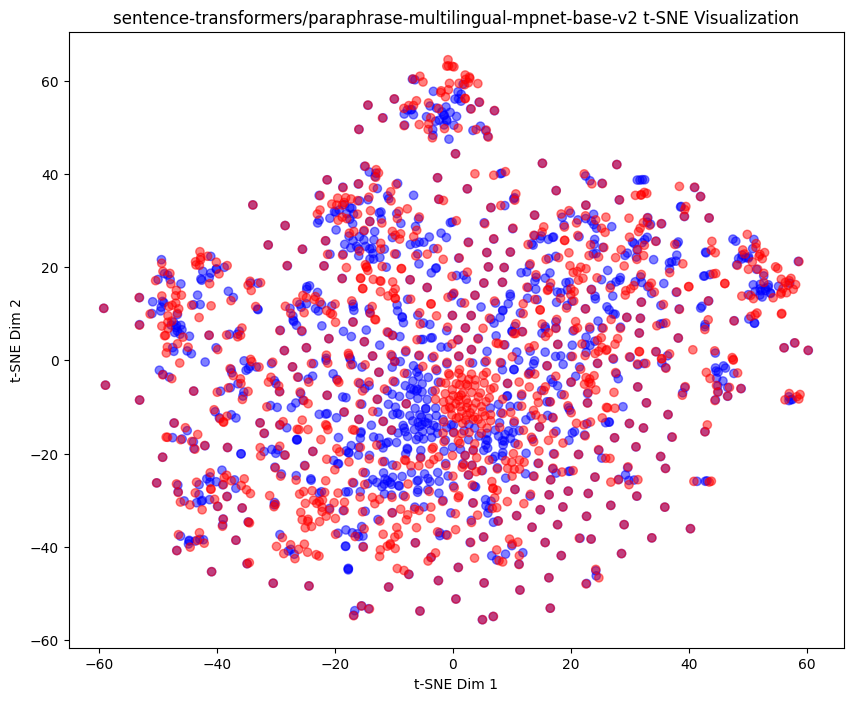

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNE uygulayarak gorsellestirdim
def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    colors = ['blue' if label == 'question' else 'red' for label in labels]
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=0.5)
    plt.title(title)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.show()

for model_name in custom_model_names:
    print(f"{model_name} için t-SNE görselleştirmesi oluşturuluyor...")
    tokenizer, model = get_model_and_tokenizer(model_name)

    # embedding alma
    question_embeddings = get_embeddings_in_batches(selected_questions, tokenizer, model).cpu().numpy()
    answer_embeddings = get_embeddings_in_batches(selected_answers, tokenizer, model).cpu().numpy()

    # t-SNE icin verileri birlestirme
    all_embeddings = np.vstack((question_embeddings, answer_embeddings))
    labels = ['question'] * len(selected_questions) + ['answer'] * len(selected_answers)

    # gorsellestirme
    plot_tsne(all_embeddings, labels, f"{model_name} t-SNE Visualization")
